In [67]:
import numpy as np
import os, sys

# project_root = os.getcwd()
project_root = os.path.abspath("")  # alternative
base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from utils import remove_all_ticks_and_labels
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # makes fonts editable in Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42

In [173]:
from likelihood_utils import variable_neural_inference, perform_variable_inference
from utils import select_model
from dataset_utils import generate_2d_swiss_roll, load_trimodal_data

# Load data
dataset_size = 1e3
# dataset = generate_2d_swiss_roll(dataset_size, rescaled=True, return_as_tensor=True)[1]
offsets = [[0,0], [4,0], [2,4]]
dataset = load_trimodal_data(dataset_size, offsets, noise=0)[:, :2]
print(dataset.shape)

x_init = dataset[np.random.randint(dataset_size)].reshape(1, -1)
# manifold_initial_point = manifold_initial_point.to(device)


prior_sampler, num_steps, ambient_dims = select_model('unconditional-dendritic', 42)
classifier = select_model('noisy-image-classifier-with-noise-info', 2)[0]

sample_size = 1e2
label = 0
mode = 'bu'
v = np.array([[2, -5]]).T
likelihood_sigma = 0.4
s_bu = 1
s_td = 0.1
sampling_method = 'seq'

if sampling_method == 'seq':
    x_seq, x_fwd_seq, x_rev_seq, label = variable_neural_inference(prior_sampler, classifier, v, x_init, mode, label, likelihood_sigma, s_bu, s_td, num_steps, sample_size, normalized_beta_schedule=True, disable_tqdm=False)
if sampling_method == 'iid':
    x_rev_iid, label = perform_variable_inference(prior_sampler, classifier, v, mode, label, likelihood_sigma, s_bu, s_td, num_steps, sample_size, normalized_beta_schedule=True, eval_at_mean=False)

size of the training set is 3000
torch.Size([3000, 2])
model loaded!
model loaded!


  0%|          | 0/100 [00:00<?, ?it/s]

(100, 101, 2)
(100, 101, 2)


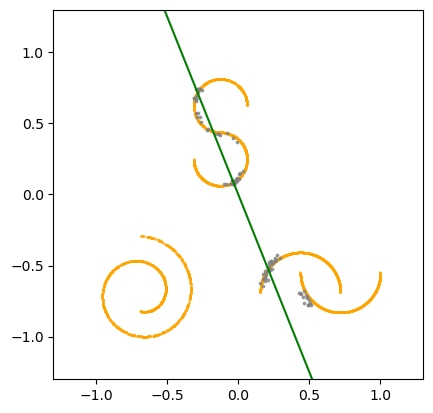

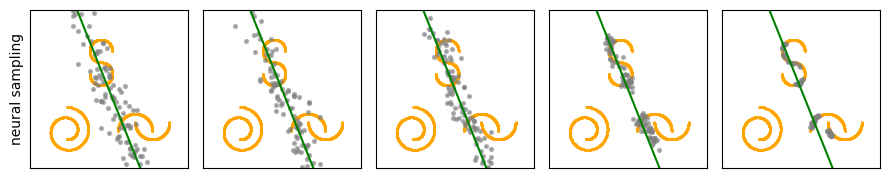

In [175]:
from plot import draw_constraint_line
from utils import remove_all_ticks_and_labels
lim = 1.3; lims = [-lim, lim]

print(x_rev_seq.shape)
fig, ax = plt.subplots(1, 1)
ax.scatter(*dataset.T, s=1, alpha=0.5, c='orange')
ax.scatter(*x_seq.T, s=3, alpha=0.7, c='grey')
ax.set(aspect='equal', xlim=lims, ylim=lims)
draw_constraint_line(ax, v, likelihood_sigma, lim, show_stdev=False)


# plot the reverse process of the sequentially generated posterior samples at different temperatures
print(x_rev_seq.shape)
fig, ax = plt.subplots(1, 5, figsize=(9, 3), sharex=True, sharey=True)
for idx, temp in enumerate([0, 1, 50, 75, 100]):
    ax[idx].scatter(*dataset.T, s=1, alpha=0.5, c='orange')
    ax[idx].scatter(*x_rev_seq[:, int(temp)].T, s=3, alpha=0.6, lw=2, c='grey', label='$p(z_t\,|\,M^T z_t)$')
    draw_constraint_line(ax[idx], v, likelihood_sigma, lim, show_stdev=False)
    ax[idx].set(aspect='equal', xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax[idx])
ax[0].set(ylabel='neural sampling')
fig.tight_layout()

In [80]:
data_bu = x_seq, x_fwd_seq, x_rev_seq, label

<class 'numpy.ndarray'>
0
921
1
792
[[-0.43592906 -0.40951264]
 [-0.37088752 -0.81707335]]


[None, (-1.3, 1.3), (-1.3, 1.3)]

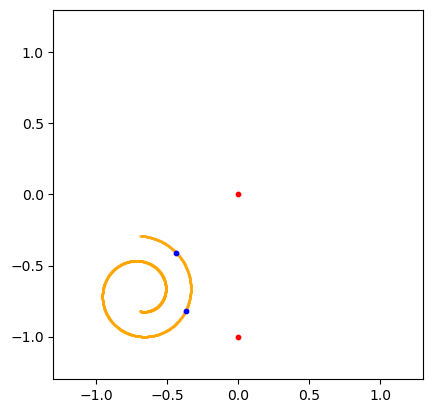

In [166]:
# calculate the closest point on the swiss roll manifold to a test point
def project_onto_clean_swiss_roll_in_trimodal_dataset(model_output, dataset_size:int = int(1e3), offsets:list = [[0,0], [4,0], [2,4]], noise:float = 0):
    from dataset_utils import generate_2d_swiss_roll
    from sklearn.datasets import make_swiss_roll, make_moons, make_s_curve
    
    # first dataset: swiss roll
    swiss_roll = generate_2d_swiss_roll(dataset_size, rescaled=False, return_as_tensor=False)[1]
    # second dataset: moons
    moons, _ = make_moons(dataset_size, noise=noise)
    # third manifold: s_curve
    s_curve, _ = make_s_curve(dataset_size, noise=noise)
    s_curve = s_curve[:, [0, 2]]/1.5
    
    def offset_manifolds(manifolds, offsets):
        manifold1 = manifolds[0] + offsets[0]
        manifold2 = manifolds[1] + offsets[1]
        manifold3 = manifolds[2] + offsets[2]
        return manifold1, manifold2, manifold3

    swiss_roll, moons, s_curve = offset_manifolds([swiss_roll, moons, s_curve], offsets)

    # convert to torch tensors and float
    swiss_roll = torch.Tensor(swiss_roll).float()
    moons = torch.Tensor(moons).float()
    s_curve = torch.Tensor(s_curve).float()

    # combine the three manifolds
    combined_dataset = torch.cat((swiss_roll, moons, s_curve), dim=0)

    from utils import rescale_samples_to_pm1
    dataset = rescale_samples_to_pm1(combined_dataset)
    swiss_roll = dataset[:int(dataset_size), :].numpy()

    calculate_distance = lambda x: np.linalg.norm(x - swiss_roll, ord=2, axis=1)
    assert model_output.shape[1] == 2
    
    min_idxs = np.zeros(model_output.shape[0], dtype=int)

    for idx in range(model_output.shape[0]):
        print(idx)
        distances = calculate_distance(model_output[idx])
        min_idx = np.argmin(distances)
        print(min_idx)
        min_idxs[idx] = min_idx
    
    return swiss_roll, min_idxs, swiss_roll[min_idxs]
    
test_points = np.array([[0, 0], [0, -1]])
swiss_roll, idxs, sr_points = project_onto_clean_swiss_roll_in_trimodal_dataset(test_points)
print(sr_points)

fig, ax = plt.subplots(1, 1)
ax.scatter(*swiss_roll.T, s=1, alpha=0.5, c='orange')
ax.scatter(*test_points.T, c='red', s=10)
ax.scatter(*sr_points.T, c='blue', s=10)
ax.set(aspect='equal', xlim=lims, ylim=lims)


In [171]:
# how many samples and trials should I run?
import zarr
# a = zarr.load(os.path.join(base_dir, 'core/saved_arrays/autocorrelation/iid_prior_samples_runs=4000_cycles=50.zarr'))
a = zarr.load(os.path.join(base_dir, 'core/saved_arrays/autocorrelation/posterior_samples/posterior_rev_samples_iid.zarr'))
print(a.shape)
# print(a[0])

(4000, 101, 50, 2)


In [ ]:
# unimodal 2D swiss roll manifold using dendritic model 47
data_neither 
data_bu

calculate the number of parameters in a network from an array of branch factors

In [42]:
def compute_number_of_parameters_from_branch_factors(branch_factor_array, num_ambient_dims, show_model=False):
    '''
    takes in an array of branch factors and computes the total number of parameters in the model, assuming the VariableDendriticCircuit model
    '''
    from models import VariableDendriticCircuit
    from utils import count_parameters

    model = VariableDendriticCircuit(hidden_cfg=branch_factor_array, num_in=num_ambient_dims, num_out=num_ambient_dims, bias=True)
    num_params = count_parameters(model)
    print('number of layers:', len(branch_factor_array)-1)
    print('total number of parameters:', num_params)
    
    # also see how many parameters are in the fully connected portion of the model
    print('number of params in FC layer:', model.features[0].linear)
    if show_model:
        print(model)
    print('\n')
    return num_params


num_ambient_dims = 2
branch_factor_array = [2, 2, 2, 2, 2, 2, 2, 2, 3, 3]
num_params = compute_number_of_parameters_from_branch_factors(branch_factor_array, num_ambient_dims)

# this is the model we used for the 2D swiss roll manifold
branch_factor_array = [3, 3, 3, 3, 3, 3, 4]
num_params = compute_number_of_parameters_from_branch_factors(branch_factor_array, num_ambient_dims)

branch_factor_array = [4, 4, 4, 4, 4, 3]
num_params = compute_number_of_parameters_from_branch_factors(branch_factor_array, num_ambient_dims)

branch_factor_array = [5, 5, 5, 5, 5]
num_params = compute_number_of_parameters_from_branch_factors(branch_factor_array, num_ambient_dims)

branch_factor_array = [8, 8, 7, 7]
num_params = compute_number_of_parameters_from_branch_factors(branch_factor_array, num_ambient_dims)

branch_factor_array = [59, 59]
num_params = compute_number_of_parameters_from_branch_factors(branch_factor_array, num_ambient_dims, True)

# from utils import select_model
# model, num_steps, dim_amb = select_model('unconditional-dendritic-10-layers', 1)
# from utils import count_parameters
# num_params = count_parameters(model)
# print(num_params)


number of layers: 10
total number of parameters: 32234
number of params in FC layer: Linear(in_features=3, out_features=4608, bias=True)


number of layers: 7
total number of parameters: 34986
number of params in FC layer: Linear(in_features=3, out_features=5832, bias=True)


number of layers: 6
total number of parameters: 34814
number of params in FC layer: Linear(in_features=3, out_features=6144, bias=True)


number of layers: 5
total number of parameters: 34372
number of params in FC layer: Linear(in_features=3, out_features=6250, bias=True)


number of layers: 4
total number of parameters: 33154
number of params in FC layer: Linear(in_features=3, out_features=6272, bias=True)


number of layers: 2
total number of parameters: 35048
number of params in FC layer: Linear(in_features=3, out_features=6962, bias=True)
VariableDendriticCircuit(
  (nonlin): ReLU()
  (features): MySequential(
    (0): NoiseConditionalLinearConcat1(
      (linear): Linear(in_features=3, out_features=6962, bia

In [66]:
def calculate_total_num_params(branch_factors: np.array):
    branch_factors = np.flip(branch_factors, axis=0)
    
    total_num_params = 0
    total_num_params += 2*np.prod(branch_factors)*4
    print('fc num features_out:', 2*np.prod(branch_factors))

    for i, b in enumerate(branch_factors):
        # print(i, b)
        # print(np.prod(branch_factors[:i]))
        num_params_current_layer = 2 * np.prod(branch_factors[:i]) * (b+1)
        total_num_params += num_params_current_layer
    print('total num params:', total_num_params)
    return total_num_params

branch_factor = [8, 8, 7, 7]
calculate_total_num_params(branch_factor)

branch_factor = [324*3, 3]
calculate_total_num_params(branch_factor)
branch_factor = [324, 9]
calculate_total_num_params(branch_factor)
branch_factor = [108, 27]
calculate_total_num_params(branch_factor)
branch_factor = [54, 54]
calculate_total_num_params(branch_factor)
branch_factor = [27, 108]
calculate_total_num_params(branch_factor)
branch_factor = [9, 324]
calculate_total_num_params(branch_factor)
branch_factor = [3, 324*3]
calculate_total_num_params(branch_factor)

# i.e. does the shape of the dendritic tree matter?

fc num features_out: 6272
total num params: 33154
fc num features_out: 5832
total num params: 29174
fc num features_out: 5832
total num params: 29198
fc num features_out: 5832
total num params: 29270
fc num features_out: 5832
total num params: 29378
fc num features_out: 5832
total num params: 29594
fc num features_out: 5832
total num params: 30458
fc num features_out: 5832
total num params: 33050


33050

calculate the autocorrelation of the posterior 

In [98]:
def generate_samples(sampling_method, distribution_type, num_runs, sample_size, save_dir, manifold_type='unimodal', v=None, eval_method=None, s_bu=None, s_td=None, posterior_type=None, label=2):
    global device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}', flush=True)
    sys.path.append(os.path.join(base_dir, 'core'))
    sys.path.append(os.path.join(base_dir, 'core/utils'))
    from pathlib import Path
    import zarr
    
    # ------------------------------- select model ------------------------------- #
    from utils import select_model
    if manifold_type == 'unimodal':
        prior_sampler, num_steps, ambient_dims = select_model('unconditional-dendritic', 47)
        normalized_beta_schedule = True
    if manifold_type == 'trimodal':
        prior_sampler, num_steps, ambient_dims = select_model('unconditional-dendritic', 42)
        normalized_beta_schedule = True
    prior_sampler.to(device)
    
    # ----------------------- define continuous likelihood ----------------------- #
    if distribution_type == 'posterior':
        if manifold_type == 'unimodal':
            v = np.array([[4, 1]]).T
            likelihood_sigma = 0.4
        elif manifold_type == 'trimodal':
            v = np.array([[2, -5]]).T
            likelihood_sigma = 0.5
        if s_bu == None:
            s_bu = 1
        if s_td == None:
            s_td = 0.1
    
    # -------- initial datapoint on the manifold (for sequential sampling) ------- #
    if sampling_method == 'seq':
        if manifold_type == 'unimodal':
            from dataset_utils import generate_2d_swiss_roll
            dataset = generate_2d_swiss_roll(sample_size, rescaled=True, return_as_tensor=True)[1]
            manifold_initial_point = dataset[np.random.randint(sample_size)].reshape(1, -1)
            manifold_initial_point = manifold_initial_point.to(device)
        if manifold_type == 'trimodal':
            from dataset_utils import load_trimodal_data
            offsets = [[0,0], [4,0], [2,4]]
            dataset = load_trimodal_data(sample_size, offsets, noise=0)[:, :2]
            manifold_initial_point = dataset[np.random.randint(sample_size)].reshape(1, -1)
            manifold_initial_point = manifold_initial_point.to(device)
            
    # -------------------------------- eval method ------------------------------- #
    if eval_method == 'xt':
        eval_at_mean = False
    elif eval_method == 'mu':
        eval_at_mean = True

    # ----------------------------- generate prior samples ----------------------------- #
    if distribution_type == 'prior':    
        if sampling_method == 'iid':
            x_rev = p_sample_loop(model, (sample_size, ambient_dims), num_steps, device, normalized_beta_schedule=normalized_beta_schedule)
            
            save_dir = os.path.join(save_dir, f'{distribution_type}-{sampling_method}-{manifold_type}/num_samples={sample_size:.0g}-num_runs={num_runs:.0g}')
            Path(save_dir).mkdir(parents=True, exist_ok=True)
            zarr.save(os.path.join(save_dir, f'{int(run_idx)}.zarr'), x_rev)
            
        elif sampling_method == 'seq':
            from prior_utils import sequential_prior_sampler
            _, x_fwd, x_rev = sequential_prior_sampler(model, manifold_initial_point, sample_size, num_steps, disable_tqdm=True, normalized_beta_schedule=normalized_beta_schedule)
            
            save_dir = os.path.join(save_dir, f'{distribution_type}-{sampling_method}-{manifold_type}/num_samples={sample_size:.0g}-num_runs={num_runs:.0g}')
            Path(save_dir).mkdir(parents=True, exist_ok=True)
            zarr.save(os.path.join(save_dir, f'{int(run_idx)}_rev.zarr'), x_rev)
            zarr.save(os.path.join(save_dir, f'{int(run_idx)}_fwd.zarr'), x_fwd)
        
        
    # ----------------------------- generate posterior samples ----------------------------- #
    elif distribution_type == 'posterior':
        classifier = select_model('noisy-image-classifier-with-noise-info', 2)[0]
        
        if sampling_method == 'iid':
            from likelihood_utils import perform_variable_inference
            save_dir = os.path.join(save_dir, f'{distribution_type}-{sampling_method}-{manifold_type}-{posterior_type}-{eval_method}/num_samples={sample_size:.0g}-num_runs={num_runs:.0g}')
            Path(save_dir).mkdir(parents=True, exist_ok=True)
            
            x_revs = []
            for run_idx in trange(num_runs, desc='run number'):
                x_rev, label = perform_variable_inference(prior_sampler, classifier, v, posterior_type, label, likelihood_sigma, s_bu, s_td, num_steps, sample_size, device, normalized_beta_schedule, eval_at_mean)
                x_revs.append(x_rev)
            zarr.save(os.path.join(save_dir, f'x_revs.zarr'), x_revs)
            
        elif sampling_method == 'seq':
            from likelihood_utils import variable_neural_inference
            save_dir = os.path.join(save_dir, f'{distribution_type}-{sampling_method}-{manifold_type}-{posterior_type}-{eval_method}/num_samples={sample_size:.0g}-num_runs={num_runs:.0g}')
            Path(save_dir).mkdir(parents=True, exist_ok=True)
            
            x_fwds = []; x_revs = []
            for run_idx in trange(num_runs, desc='run number'):
                _, x_fwd, x_rev, label = variable_neural_inference(prior_sampler, classifier, v, manifold_initial_point, posterior_type, label, likelihood_sigma, s_bu, s_td, num_steps, sample_size, device, normalized_beta_schedule, eval_at_mean, disable_tqdm=True)
                x_fwds.append(x_fwd)
                x_revs.append(x_rev)
            zarr.save(os.path.join(save_dir, f'x_revs.zarr'), x_revs)
            zarr.save(os.path.join(save_dir, f'x_fwds.zarr'), x_fwds)
            


In [99]:
sample_size = 50
num_runs = 10

save_dir = os.path.join(base_dir, 'core', 'saved_arrays', 'samples')
from pathlib import Path
Path(save_dir).mkdir(parents=False, exist_ok=True)

distribution_type = 'posterior'
sampling_methods = ['iid', 'seq']

# only for posterior distribution
manifold_types = ['unimodal']
eval_methods = ['xt']
posterior_types = ['bu']

for sampling_method in sampling_methods:
    for manifold_type in manifold_types:
        for eval_method in eval_methods:
            for posterior_type in posterior_types:
                generate_samples(sampling_method, distribution_type, num_runs, sample_size, save_dir, manifold_type, eval_method=eval_method, posterior_type=posterior_type)

Using device: cpu
model loaded!
model loaded!


run number:   0%|          | 0/10 [00:00<?, ?it/s]

Using device: cpu
model loaded!
model loaded!


run number:   0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
from likelihood_utils import variable_neural_inference, sequential_posterior_sampler
from utils import select_model
from dataset_utils import generate_2d_swiss_roll
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
prior_sampler, num_steps, dim_amb = select_model('unconditional-dendritic-4-layers', 5)
classifier = None
dataset = generate_2d_swiss_roll(dataset_size, rescaled=True, return_as_tensor=False)[1]
dataset_size = 1e3
manifold_initial_point = dataset[np.random.randint(dataset_size)].reshape(1, -1)
posterior_type = 'bu'
label = None
v = np.array([[4, 1]]).T
M = v / np.linalg.norm(v)
likelihood_sigma = 0.4
s_bu = 1
s_td = 0.2
normalized_beta_schedule = False
eval_at_mean = False
schedule = 'sine'
sample_size = 1e3
_, x_fwd, x_rev, label = variable_neural_inference(prior_sampler, classifier, v, manifold_initial_point, posterior_type, label, likelihood_sigma, s_bu, s_td, num_steps, sample_size, device, normalized_beta_schedule, eval_at_mean, disable_tqdm=False, schedule=schedule)
# x_samples, x_rev_seq = sequential_posterior_sampler(prior_sampler, manifold_initial_point, M, likelihood_sigma, s_bu, sample_size, n_steps=num_steps, burn=True, normalized_beta_schedule=normalized_beta_schedule, eval_at_mean=False, device=device, status_bar=True, disable_tqdm=False)


device: cuda
model loaded!


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 